In [2]:
%load_ext autoreload
%autoreload 2

import utils as utl
from pathlib import Path
import pandas as pd

cfg = utl.load_config('./config_local.yml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example fly

## distance from ball

In [2]:
# load HDF file
data = utl.load_data_hdf(cfg)

# load specific fly
df = data['P9LT'].groupby('flynum').get_group(1)
df = utl.filter_frames(df)

# remove previous stepcycle predictions
cols = [ c for c in df.columns if c.endswith('stepcycle') ]
df = df.drop(columns=cols)

INFO: loading file data\Ballsystem_LegKinematics_DataStructures\P9_BPN\alldata_V6.h5
INFO: found genotype BPN
INFO: Renaming stepcycle columns
INFO: found genotype P9LT
INFO: Renaming stepcycle columns
INFO: found genotype P9RT
INFO: Renaming stepcycle columns


In [6]:
# inital guess for center and radius 
r0 = 3
ball0 = utl.get_ball0(df)
print('Initial guess : ball center x = {:1.3f} y = {:1.3f} z = {:1.3f} | radius {:1.3f}'.format(*ball0, r0))

Initial guess : ball center x = 0.081 y = 3.796 z = 90.726 | radius 3.000


In [8]:
# define percentiles for each leg
d_perc = {
    'R-F':  (25, 75),
    'R-M':  (25, 75),
    'R-H':  (25, 75),
    'L-F':  (25, 75),
    'L-M':  (25, 75),
    'L-H':  (25, 75),
}
# fit ball
ball, r = utl.fit_ball(df, ball0, r0, d_perc)
print('Optimized: ball center x = {:1.3f} y = {:1.3f} z = {:1.3f} | radius {:1.3f}'.format(*ball, r))

# add distances from center to df
df = utl.add_distance(df, ball)

Optimized: ball center x = -0.037 y = 3.476 z = 90.624 | radius 2.825


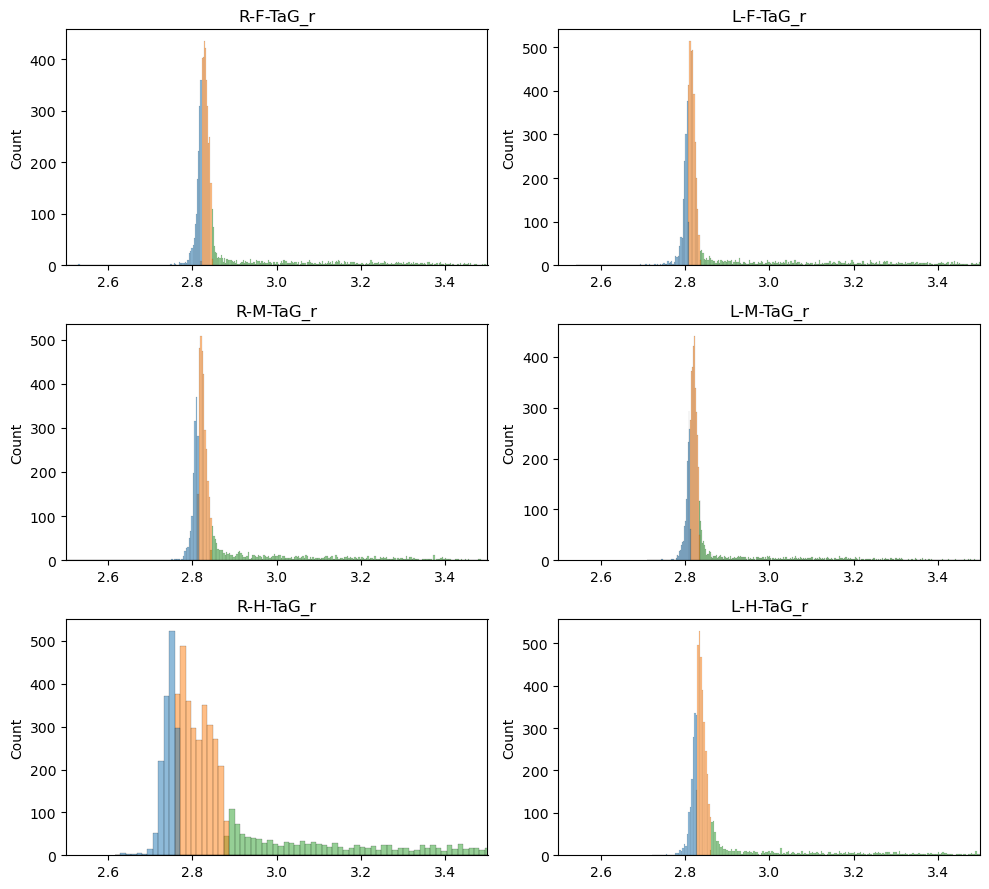

In [9]:
# plot distribution of distances 
utl.plot_r_distr(df, 'TaG_r', d_perc, xlims=(2.5, 3.5))

## Stepcycle predictions

In [10]:
# get "median" for TaG_r for each leg
d_med = utl.get_r_median(df, d_perc)

# thresholds for step detection
delta_r, min_on, min_off = 0.05, 2, 2 # distance from median and mimimum number of frames for on/off step 
df = utl.add_stepcycle_pred(df, d_med, delta_r, min_on, min_off)

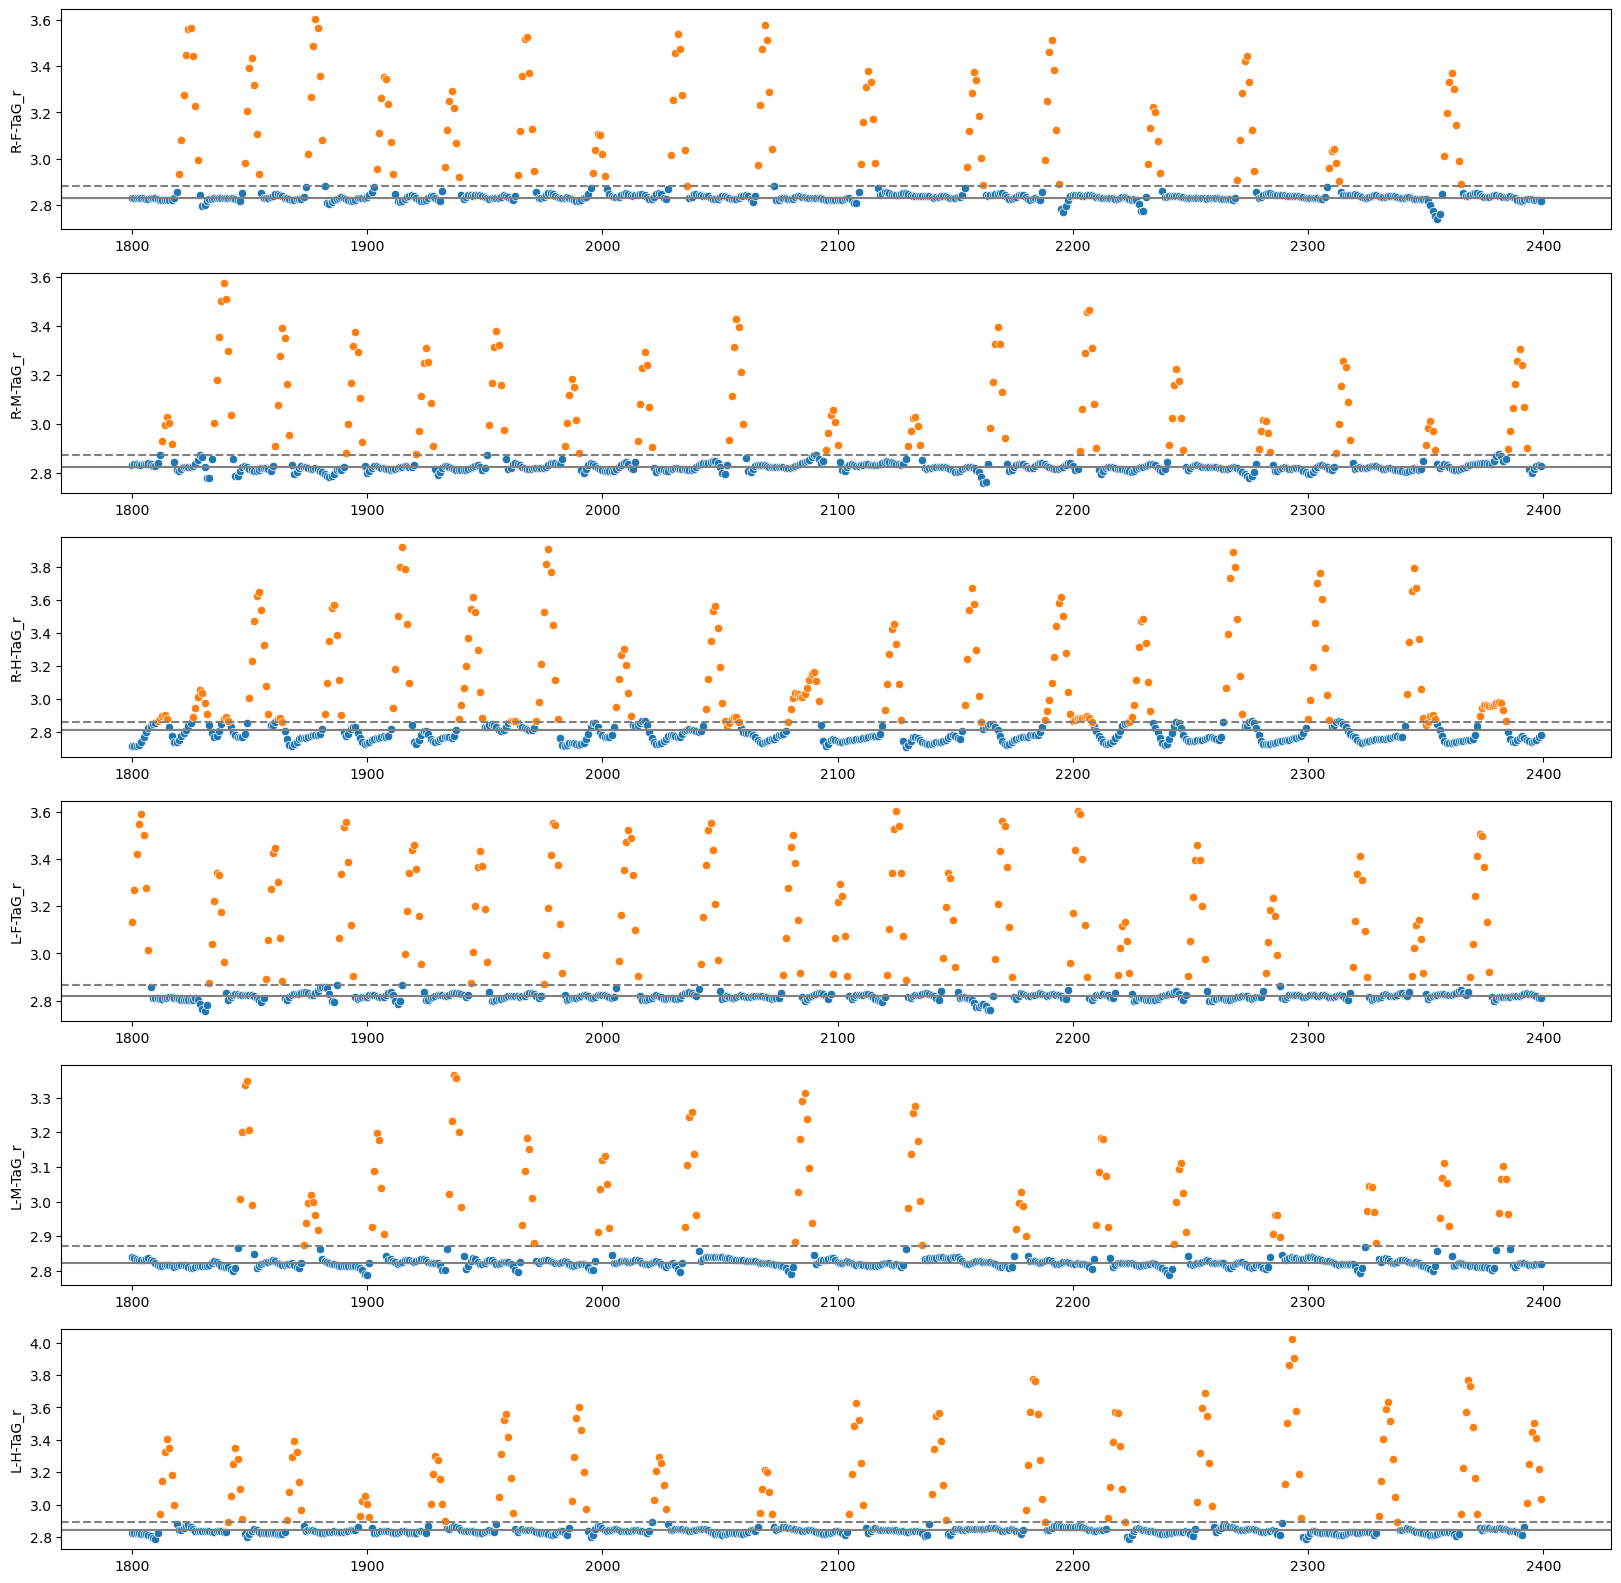

In [11]:
# plot example trial
utl.plot_stepcycle_pred(df.groupby('tnum').get_group(2), d_med, delta_r)

## fly-centric cooridnate system

In [32]:
# load HDF file
data = utl.load_data_hdf(cfg)

# tranform coordinates
df = data['P9LT'].groupby('flynum').get_group(1)
df = utl.transform_to_flycentric(df)

INFO: loading file data\Ballsystem_LegKinematics_DataStructures\P9_BPN\alldata_V6.h5
INFO: found genotype BPN
INFO: Renaming stepcycle columns
INFO: found genotype P9LT
INFO: Renaming stepcycle columns
INFO: found genotype P9RT
INFO: Renaming stepcycle columns
INFO: Fitted plane through ThC points
      a = -0.21, b = -9.32, c = 89.66, residual = 297.2
INFO: Constructing basis based on
      ThC plane a = -0.214 | b = -9.320 | c =  89.662
      notum x = -0.109 (0.001) | y = -0.682 (0.001) | z =  90.316 (0.003)
      R-WH  x =  0.187 (0.004) | y = -0.461 (0.002) | z =  89.957 (0.003)
      L-WH  x =  0.156 (0.001) | y = -0.479 (0.001) | z =  90.721 (0.002)
INFO: Transforming to fly-centric coordinates


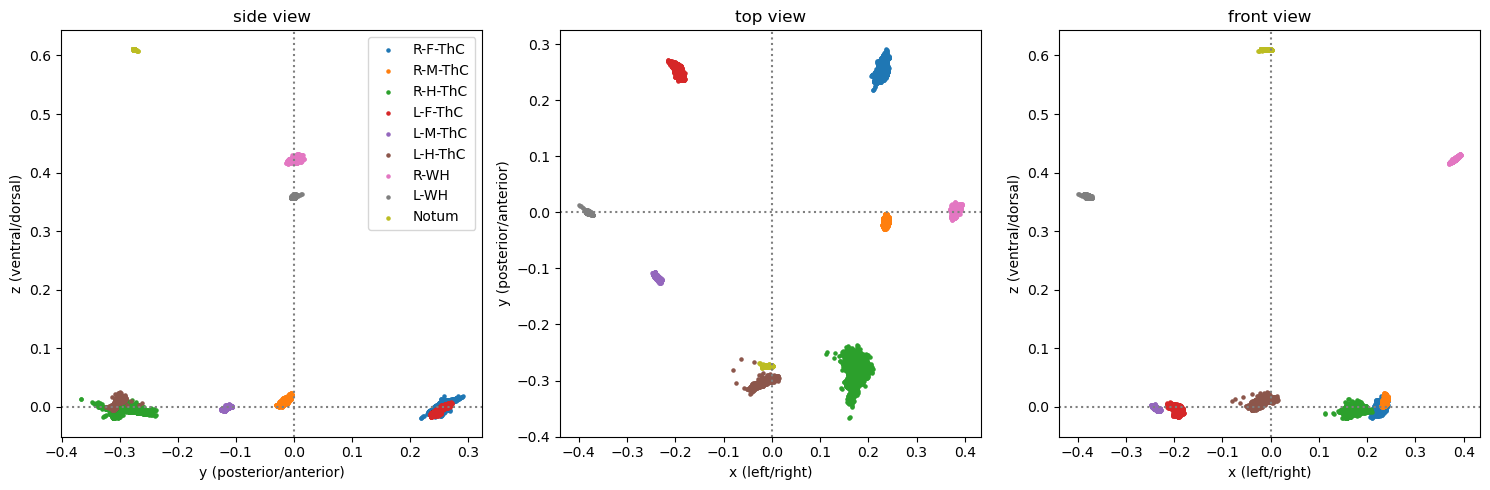

In [33]:
# plot ThC, Notum, WH
utl.plot_coord_system(df)

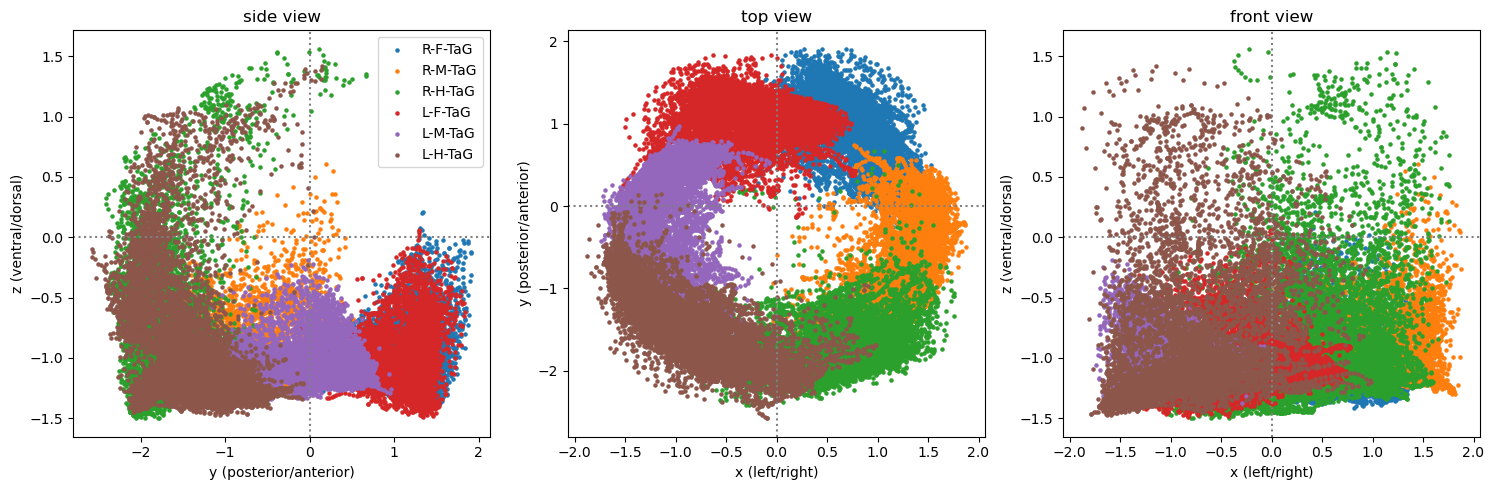

In [34]:
# plot TaG
utl.plot_coord_system(df, joints=['TaG'])

# batch pre-processing

## ball fitting and stepcycle predictions

In [ ]:
# load data
data = utl.load_data_hdf(cfg)

# inital guess for center and radius 
r0 = 3

# define percentiles for each leg
d_perc = {
    'R-F':  (25, 75),
    'R-M':  (25, 75),
    'R-H':  (25, 75),
    'L-F':  (25, 75),
    'L-M':  (25, 75),
    'L-H':  (25, 75),
}
    
# thresholds for step detection
delta_r, min_on, min_off = 0.05, 2, 2 # distance from median and mimimum number of frames for on/off step 

# data frame for ball centers / radii
df_ball = pd.DataFrame()

# cycle trough genotypes
idx = 0
for gen, df_gen in data.items():

    # plot folder
    plot_folder = Path(cfg['plot_folder']) / 'ball_predictions/{}/'.format(gen)
    plot_folder.mkdir(parents=True, exist_ok=True)

    # cycle through flies
    for fly, df_fly in df_gen.groupby('flynum'):

        print('INFO: processing genotype {} | fly {}'.format(gen, fly))
        print('      ==================='.format(gen, fly))
        
        #######################
        ## only use stim frames
        df = utl.filter_frames(df_fly)

        # inital guess for center
        ball0 = utl.get_ball0(df)
        print('Initial guess : ball center x = {:1.3f} y = {:1.3f} z = {:1.3f} | radius {:1.3f}'.format(*ball0, r0))

        # fit ball
        ball, r = utl.fit_ball(df, ball0, r0, d_perc)
        print('Optimized: ball center x = {:1.3f} y = {:1.3f} z = {:1.3f} | radius {:1.3f}'.format(*ball, r))

        # add distances from center 
        df = utl.add_distance(df, ball)

        # get "median" for TaG_r for each leg
        d_med = utl.get_r_median(df, d_perc)

        # write to df_ball
        df_ball.loc[idx, 'genotype'] = gen
        df_ball.loc[idx, 'flynum'] = fly
        df_ball.loc[idx, ['ball0_x', 'ball0_y', 'ball0_z']] = ball0
        df_ball.loc[idx, 'r0'] = r0
        df_ball.loc[idx, ['ball_x', 'ball_y', 'ball_z']] = ball
        df_ball.loc[idx, 'r'] = r
        # for k, v in d_perc.items():
        #     df_ball.at[idx, 'perc_{}'.format(k)] = v
        idx += 1

        #######################
        ## all frames

        # add distances from center 
        df_fly = utl.add_distance(df_fly, ball)

        # step cycles
        df_fly = utl.add_stepcycle_pred(df_fly, d_med, delta_r, min_on, min_off)

        # add back to data dict
        data[gen].loc[df_fly.index, :] = df_fly

        #####################
        ## plot for stim only
        df = utl.filter_frames(df_fly)

        # plot r distribution
        utl.plot_r_distr(df, 'TaG_r', d_perc, path=plot_folder / 'r_distr_fly{}.png'.format(fly))
        
        # plot stepcycles 
        utl.plot_stepcycle_pred_grid(df, d_med, delta_r, path=plot_folder / 'stepcycles_{}.png'.format(fly))

# store on disk
path_df_ball = Path(cfg['data_folder']) / 'df_ball.parquet'
df_ball.to_parquet(path_df_ball)

out_file = Path(cfg['data_folder']) / 'df_preproc.parquet'
utl.write_data_dict(data, out_file)

## coordinate transformation

In [ ]:
# load preprocessed data from disk
out_file = Path(cfg['data_folder']) / 'df_preproc.parquet'
data = utl.load_data_dict(out_file)

# cycle trough genotypes
for gen, df_gen in data.items():

    # cycle through flies
    for fly, df_fly in df_gen.groupby('flynum'):

        print('INFO: processing genotype {} | fly {}'.format(gen, fly))
        print('      ==================='.format(gen, fly))

        # convert to fly-centric coordinates
        df = utl.transform_to_flycentric(df_fly)
        data[gen].loc[df.index, :] = df


# store on disk
out_file = Path(cfg['data_folder']) / 'df_preproc.parquet'
utl.write_data_dict(data, out_file)

In [ ]:
# plot
# load preprocessed data from disk
out_file = Path(cfg['data_folder']) / 'df_preproc.parquet'
data = utl.load_data_dict(out_file)

# cycle trough genotypes
for gen, df_gen in data.items():

    dir_out = Path(cfg['plot_folder']) / 'fly_centric_coords/{}/'.format(gen)
    dir_out.mkdir(parents=True, exist_ok=True)

    # cycle through flies
    for fly, df_fly in df_gen.groupby('flynum'):
        utl.plot_coord_system(df_fly, path=dir_out / 'flynum_{}.png'.format(fly))
